## Anomaly detection in Endecopic images
### pre-trained model : ResNet50

call to packages & libraries

In [1]:
import sys
import os
from tensorflow import keras
from datetime import datetime

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\sup")

from evaluation import *
from support import *
from test_set_eval import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12486716065983710410
]


In [3]:
model_name = "ResNet50_tl"


In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


callout dataset

In [5]:
classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus',
           'normal-z-line', 'polyps', 'ulcerative-colitis']
root_dir = '../../data/kvasir-dataset-v2'
weights_path = '../../data/model/resnet50_weights_tf_dim_ordering_tf_kernels.h5'


take a glance at training dataset

In [ ]:
plot_sample_of_img(4,4,os.listdir(tr_heart_dir)+os.listdir(tr_eye_dir))

ImageGenator - autolabelling, and categorizing.

In [11]:
train_gen_tmp = ImageDataGenerator(rescale=1. / 255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_gen = train_gen_tmp.flow_from_directory(root_dir,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              seed=42,
                                              subset='training')

validation_gen = train_gen_tmp.flow_from_directory(root_dir,
                                                   target_size=(224, 224),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=False,
                                                   seed=42,
                                                   subset='validation')

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = validation_gen.n // validation_gen.batch_size

clToInt_dict = train_gen.class_indices
clToInt_dict = dict((k, v) for v, k in clToInt_dict.items())

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


define the model

In [6]:
# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# md = 'resnet50'
# logdir = '../../logs/func/%s' % md
# writer = tf.summary.create_file_writer(logdir)

# tf.summary.trace_on(graph=True, profiler=True)


model = ResNet50(input_shape=(224,224,3),
                 weights = "imagenet",
                 include_top = True)
# model.load_weights(weights_path)
# model.summary()
# with writer.as_default():
#   tf.summary.trace_export(
#       name="my_func_trace",
#       step=0,
#       profiler_outdir=logdir)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
pre_model = ResNet50(input_shape=(224,224,3),
                 weights = "imagenet",
                 include_top = True)

for layer in pre_model.layers:
    layer.trainable = False

conn_layer = pre_model.get_layer('conv4_block6_out')
conn_output = conn_layer.output
x = GlobalMaxPooling2D()(conn_output)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512,activation='relu')(x)
x = Dense(8,activation='softmax')(x)

model = Model(pre_model.input,x)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

compile the model

In [13]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

save the log

In [14]:

# Define the Keras TensorBoard callback.
logdir="../../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

if not os.path.exists(logdir):
    os.mkdir(logdir)

#print(datetime.now().strftime("%Y%m%d%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)

fit & train the model.

In [15]:
history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    verbose=1,
                    callbacks= [tensorboard_callback])

Epoch 1/15
200/200 [==============================] - 547s 3s/step - loss: 1.9528 - accuracy: 0.3256 - val_loss: 3.5881 - val_accuracy: 0.1519
Epoch 2/15
200/200 [==============================] - 532s 3s/step - loss: 1.5953 - accuracy: 0.3842 - val_loss: 1.4645 - val_accuracy: 0.3837
Epoch 3/15
200/200 [==============================] - 533s 3s/step - loss: 1.4507 - accuracy: 0.4095 - val_loss: 1.3845 - val_accuracy: 0.4319
Epoch 4/15
200/200 [==============================] - 543s 3s/step - loss: 1.3640 - accuracy: 0.4342 - val_loss: 1.3421 - val_accuracy: 0.4375
Epoch 5/15
200/200 [==============================] - 524s 3s/step - loss: 1.3439 - accuracy: 0.4367 - val_loss: 1.2998 - val_accuracy: 0.4506
Epoch 6/15
200/200 [==============================] - 520s 3s/step - loss: 1.3172 - accuracy: 0.4455 - val_loss: 1.2466 - val_accuracy: 0.4744
Epoch 7/15
200/200 [==============================] - 520s 3s/step - loss: 1.2828 - accuracy: 0.4625 - val_loss: 1.2123 - val_accuracy: 0.4938

visualize layer process in cnn

In [ ]:
#visualize_model(model,img_path)

instant evaluation

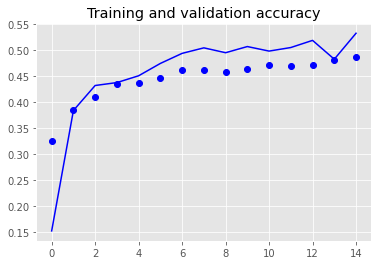

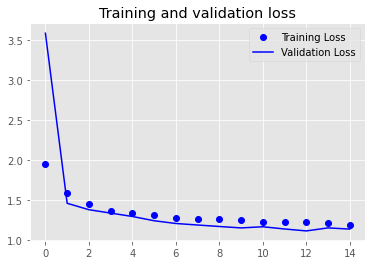

In [16]:
#call to the tensorboard
#%tensorboard --logdir logs
#look at training model performance
acc_n_loss(history)

#model.evaluate_generator(validation_gen,
#                         steps=STEP_SIZE_VALID)

evaluate the model on test set.

In [17]:
pred = model.predict_generator(validation_gen,
                                verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)
labels = (validation_gen.class_indices)
class_to_int = dict((k, v) for k, v in labels.items())

img_classes = validation_gen.filenames
#print(img_classes)
test_y = [j.split("\\")[0] for j in img_classes]
test_gen = [class_to_int[i] for i in test_y]

Instructions for updating:
Please use Model.predict, which supports generators.
50/50 [==============================] - 106s 2s/step


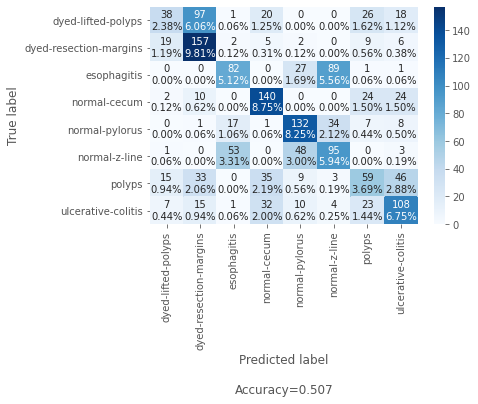

In [18]:
plot_confusion_metrix(test_gen,predicted_class_indices,classes)


In [ ]:
y_pred,y_test = test_eval(model,classes)
plot_confusion_metrix(y_test,y_pred,classes)
ROC_classes(6,y_test,y_pred,classes)



save the model in .h5 file

In [ ]:
model_path,model_weight_path = save(model,datetime.now().strftime("%Y%m%d%H%M%S")+model_name+'.h5')

make prediction on random images

In [ ]:
#rnd_predict(model_path,model_weight_path,img_path,clToInt_dict)
